In [87]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import Qt


In [88]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
from commpy.filters import rcosfilter
from ipywidgets import interact, widgets

In [89]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [90]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [91]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [92]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)
    plt.figure(figure_counter)
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    return yf

In [93]:
def gen_rcfilter_impulse_response(n, fs):
    s_psf = rcosfilter(n * fs, alpha=0.24, Ts=1, Fs=fs)[1][1:]
    print(s_psf)
    plt.figure()
    plt.plot(s_psf, '*-')
    plt.grid()
    plt.title('RC filter impulse response')
    plt.show()
    return s_psf

In [94]:
def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    j_exp = np.exp(1j * np.pi * f0_to_fsig * n)
    print("complex exp")
    print(j_exp[0 : 20])
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    return sig * mixer

In [95]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [96]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    print(len(data))
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(n_symb * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

[ 4.24996460e-06  7.80681981e-06  1.00473518e-05  1.06096386e-05
  9.46490890e-06  6.91708197e-06  3.53015446e-06 -1.42863282e-19
 -3.00015110e-06 -4.96525263e-06 -5.66180926e-06 -5.16569850e-06
 -3.82639780e-06 -2.16685201e-06 -7.43433574e-07  4.61964924e-21
 -1.51629103e-07 -1.12674664e-06 -2.58256731e-06 -3.99121783e-06
 -4.77670319e-06 -4.47010141e-06 -2.84513962e-06 -4.16635826e-20
  3.63686506e-06  7.38161233e-06  1.04361963e-05  1.20652840e-05
  1.17688807e-05  9.41035207e-06  5.26863180e-06 -1.79753096e-19
 -5.48480673e-06 -1.02028862e-05 -1.33015042e-05 -1.42357985e-05
 -1.28820258e-05 -9.56057570e-06 -4.96312666e-06  2.40699928e-20
  4.39801342e-06  7.47858044e-06  8.82247665e-06  8.41908649e-06
  6.64619334e-06  4.15978944e-06  1.72072998e-06 -5.96968215e-20
 -5.90424284e-07  7.73447676e-20  1.45009430e-06  3.15227033e-06
  4.37379020e-06  4.45551562e-06  2.99972529e-06 -8.23022442e-20
 -4.12112841e-06 -8.57986133e-06 -1.23923623e-05 -1.45949744e-05
 -1.44736440e-05 -1.17488

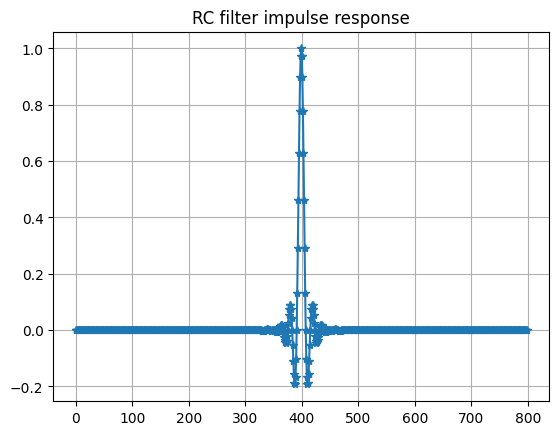

10000000


In [97]:
N = 100
Fs = 8 # f_sampling / f_symbol (SPS)
f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1
N_symb = N * 100000
s_rc = gen_rcfilter_impulse_response(N, Fs)
s_qpsk = gen_qpsk_symbols(N_symb, Fs)
qpsk_filtered = np.convolve(s_qpsk, s_rc, 'same')

In [98]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

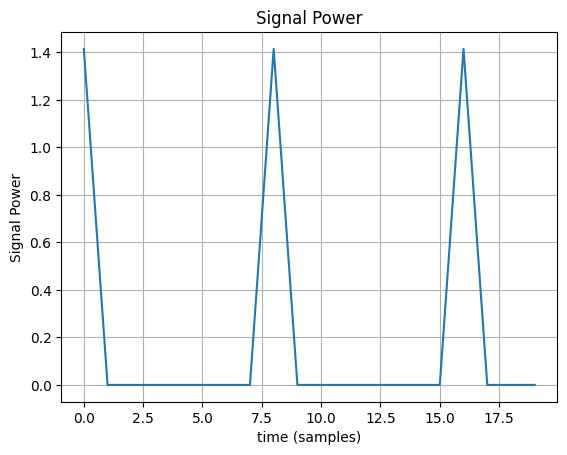

In [99]:
plot_signal_power(abs(s_qpsk[:20]), 0)

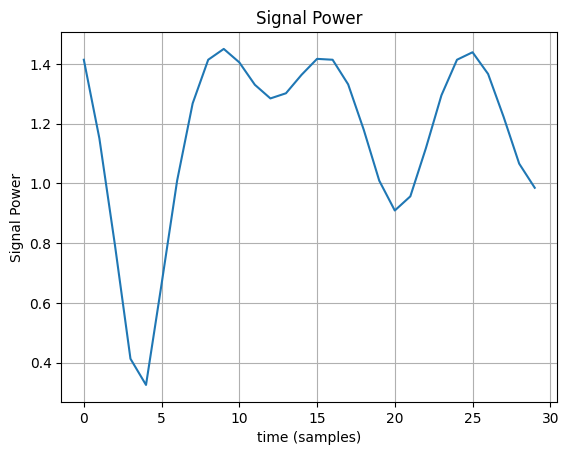

In [100]:
plot_signal_power(abs(qpsk_filtered[:30]), 0)

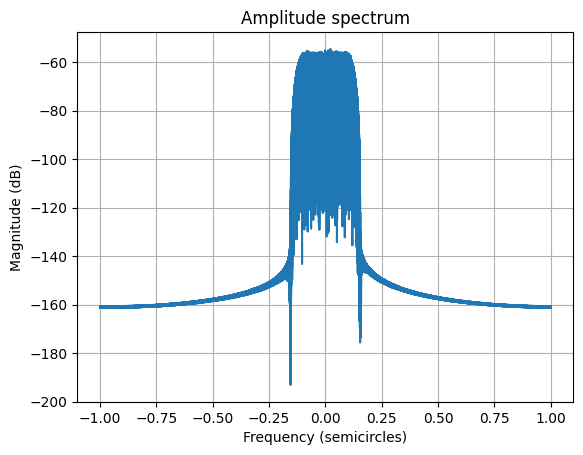

In [101]:
spectr = plot_spectrum(qpsk_filtered, 1)

complex exp
[ 1.00000000e+00+0.00000000e+00j  6.12323400e-17+1.00000000e+00j
 -1.00000000e+00+1.22464680e-16j -1.83697020e-16-1.00000000e+00j
  1.00000000e+00-2.44929360e-16j  3.06161700e-16+1.00000000e+00j
 -1.00000000e+00+3.67394040e-16j -4.28626380e-16-1.00000000e+00j
  1.00000000e+00-4.89858720e-16j  5.51091060e-16+1.00000000e+00j
 -1.00000000e+00+6.12323400e-16j -2.44991258e-15-1.00000000e+00j
  1.00000000e+00-7.34788079e-16j -9.80336420e-16+1.00000000e+00j
 -1.00000000e+00+8.57252759e-16j -2.69484194e-15-1.00000000e+00j
  1.00000000e+00-9.79717439e-16j -7.35407060e-16+1.00000000e+00j
 -1.00000000e+00+1.10218212e-15j -2.93977130e-15-1.00000000e+00j]


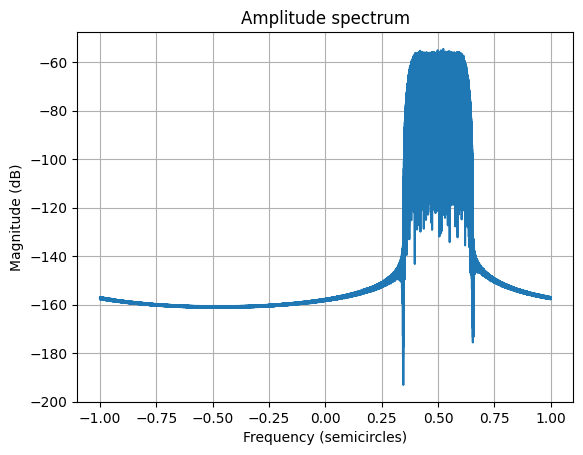

In [102]:
mixed_qpsk = add_freq(qpsk_filtered, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
spectr = plot_spectrum(mixed_qpsk,2)

(4.670291235023723-1.5025610632265514j)
4.670291235023723
4.671444750580671
7014.3182140657855


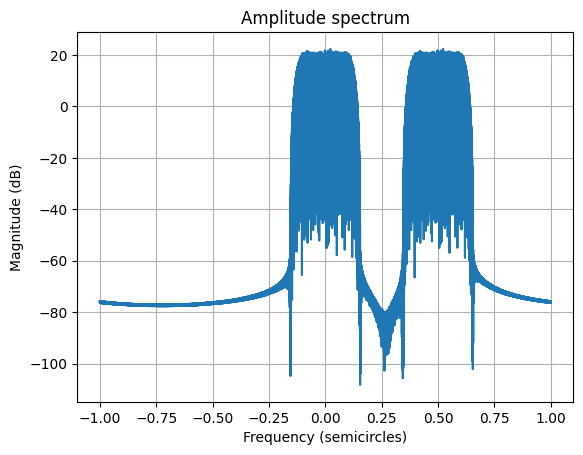

In [103]:
two_sigs = mixed_qpsk + qpsk_filtered
max_i16 = 32767
print(max(two_sigs))
print(max(two_sigs.real))
print(max(two_sigs.imag))
coeff = max_i16 / max(max(two_sigs.real), max(two_sigs.imag))
print(coeff)
two_sigs *= np.floor(coeff)
spectr = plot_spectrum(two_sigs, 3)

In [104]:


s_re = two_sigs.real
s_im = two_sigs.imag
arr_int16_re = s_re.astype(np.int16)
arr_int16_im = s_im.astype(np.int16)
arr_int = np.empty(len(two_sigs) * 2, dtype=int)
print(len(arr_int))
arr_int[ : : 2] = arr_int16_re
arr_int[1 : : 2] = arr_int16_im
saved_arr = arr_int.astype(np.int16)
print(saved_arr[:30])
with open('cmplx_int16_arr.bin', 'wb') as f:
    saved_arr.tofile(f)

np.save('qpsk_sigs.pcm', saved_arr)

160000000
[ -5462 -16811   2581  -4269  -5033    497  -2463  -4928   4034    514
      8   2873   5396  -3490  15915   5738   5462  16811  -3628   5135
   8949    111   9094  15242  -8062  13886  -5642   -107   4464   7448]
